In [1]:
import numpy as np
from sklearn.neural_network import MLPClassifier
import random
import torch
from scipy.special import erf
import matplotlib.pyplot as plt
from math import*
from scipy.integrate import quad as itg
from torch.utils.data import DataLoader, Dataset
#torch
import torch
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from torchvision import transforms
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [71]:
d=2000      #dimension

N=54000     #Generating N samples from the target density. A subset will be used as the training set

In [72]:


X_train=np.random.randn(N,d)
X_test=np.random.randn(N,d)

#centroids
mu1=np.zeros((int(N/3),d))
mu2=np.zeros((int(N/3),d))
mu3=np.zeros((int(N/3),d))

mu1[:,0]=np.ones(int(N/3))
mu2[:,0]=-np.ones(int(N/3))
mu3[:,1]=-np.ones(int(N/3))

mean=np.vstack((mu1,mu3,mu2))
mean=3*mean
assert mean.shape==X_train.shape

mu=torch.from_numpy(np.vstack((mu1[0],mu3[0],mu2[0])).astype(np.float32)).to(device)
mu=mu*3

X_train=X_train+mean
X_test=X_test+mean

X_train= X_train.astype(np.float32)
X_test= X_test.astype(np.float32)

X_test=X_test[:2000]
X_train=X_train[:]
n, d = X_train.shape



In [73]:
X_test=torch.from_numpy(X_test)
X_train=torch.from_numpy(X_train)


In [74]:

T=1   #discretization of t in the denoising objective. For simplicity, we consider a single noise level t=0.7

X_tr=X_train.unsqueeze(2)
Xis=torch.randn(X_tr.shape)

Xt=Xis.clone()
X1t=X_tr.clone()

X_ts=X_test.unsqueeze(2)
Xis_test=torch.randn(X_ts.shape)
Xt_test=Xis_test.clone()
X1t_test=X_ts.clone()

                  #if using several time levels
for k in range(1):#for k in range(1,T+1):
  t=.7            #t=k/T
  X_add=t*X_tr+(1-t)*Xis
  Xt=torch.cat((Xt, X_add), dim=2)
  X1t=torch.cat((X1t, X_tr), dim=2)

  X_add_test=t*X_ts+(1-t)*Xis_test
  Xt_test=torch.cat((Xt_test, X_add_test), dim=2)
  X1t_test=torch.cat((X1t_test, X_ts), dim=2)

if T==1:   #if we take a single noise level, we remove the first entry which corresponds to t=0 and is always present
  Xt=Xt[:,:,-1].unsqueeze(2)
  X1t=X1t[:,:,-1].unsqueeze(2)
  Xt_test=Xt_test[:,:,-1].unsqueeze(2)
  X1t_test=X1t_test[:,:,-1].unsqueeze(2)



In [75]:
#shuffling the dataset
indices = torch.randperm(N)
Xt=Xt[indices]
X1t=X1t[indices]


# Training the autoencoder

In [76]:
class generate_data(Dataset):
  def __init__(self,n):
    self.idx=random.sample(range(N),n)

    self.X=Xt.to(device)
    self.X1=X1t.to(device)
    self.samples=n


  def __getitem__(self,idx):
    return self.X[idx].to(device), self.X1[idx].to(device)

  def __len__(self):
    return self.samples


In [77]:
class AE(torch.nn.Module):
    def __init__(self, d,r, informed=False):
        super(AE, self).__init__()
        np.random.seed(42)
        w0=torch.zeros((r,d))
        w0[:min(r,3),:]=mu[:min(r,3)]*np.sqrt(d)*.1
        init=w0.T

        self.r=r                                      #number of hidden units
        self.we=torch.nn.Parameter(init)              #weight matrix
        self.skip=torch.nn.Parameter(torch.randn(1)*0)#skip connection.

    def forward(self, x):
        x=x
        identity=x
        h1=torch.einsum("ij, nit->njt",self.we,x)/np.sqrt(d)
        h=torch.tanh(h1)
        yhat = torch.einsum("ij, njt->nit",self.we,h)/np.sqrt(d)
        yhat+=self.skip*identity

        return yhat

In [78]:
def quadloss(ypred, y):
    return torch.sum((ypred-y)**2)

In [79]:

def train(train_loader, informed=False,verbose=False):
    ae=AE(d, r=r, informed=informed).to(device)


    #optimizer = torch.optim.Adam(ae.parameters(), lr=.01,weight_decay=.5)
    optimizer = torch.optim.SGD([{'params': [ae.we],"weight_decay":0.1/d, "lr":.1},{'params': [ae.skip],"weight_decay":0., "lr":.1/d**2}])

    #gen_loss_list=[]
    Q_list=[]
    M_list=[]
    b_list=[]

    Q_list.append(((ae.we).T@ae.we/d).detach().cpu().numpy())
    M_list.append(((ae.we).T@mu.T/np.sqrt(d)).detach().cpu().numpy())
    b_list.append(float((ae.skip).detach().cpu()))
    for t in range(1):
        for x,y in train_loader:
          y_pred = ae(x)
          loss = quadloss(y_pred,y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          Q_list.append(((ae.we).T@ae.we/d).detach().cpu().numpy())           #measure summary statistic Q
          M_list.append(((ae.we).T@mu.T/np.sqrt(d)).detach().cpu().numpy())   #measure summary statistic M
          b_list.append(float((ae.skip).detach().cpu()))                      #measure skip connection b


    return ae.we.detach().cpu().numpy(),  float(ae.skip.detach().cpu()), Q_list, M_list,b_list

In [82]:
samples=40000
r=2
training_set=generate_data(samples)
train_loader=DataLoader(training_set,batch_size=int(1),shuffle=True)
we,skip,Q,M,b=train(train_loader, informed=True)

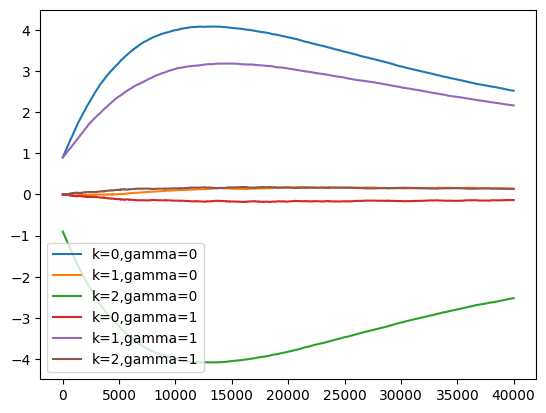

In [83]:
plt.plot(range(samples+1), np.array(M)[:,0,0], label="k={},gamma={}".format(0,0))
plt.plot(range(samples+1), np.array(M)[:,0,1], label="k={},gamma={}".format(1,0))
plt.plot(range(samples+1), np.array(M)[:,0,2], label="k={},gamma={}".format(2,0))
plt.plot(range(samples+1), np.array(M)[:,1,0], label="k={},gamma={}".format(0,1))
plt.plot(range(samples+1), np.array(M)[:,1,1], label="k={},gamma={}".format(1,1))
plt.plot(range(samples+1), np.array(M)[:,1,2], label="k={},gamma={}".format(2,1))
plt.legend()



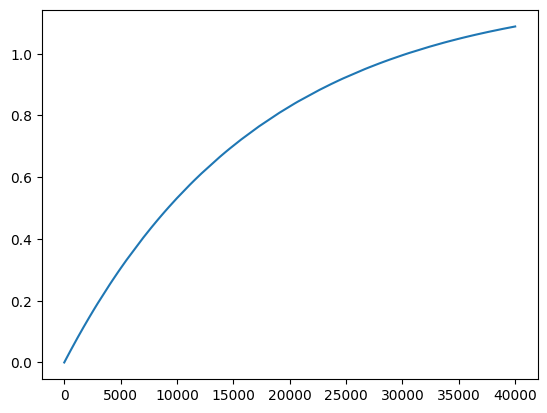

In [84]:
plt.plot(range(samples+1), b)

In [85]:
np.save("M_simu.npy",np.array(M))
np.save("Q_simu.npy",np.array(Q))
np.save("b_simu.npy",np.array(b))

# Sampling

In [86]:
T_gen=100
dt=1/T_gen
N=2000
X=np.random.randn(N, d)

for k in range(T_gen-1):
  t=k/T_gen
  velocity=(1+t/(1-t))*(skip*X + np.tanh(X@we/np.sqrt(d))@we.T/np.sqrt(d))-1/(1-t)*X
  X=X+velocity*dt







In [87]:
np.save("Samples_simus.npy",X)

<ipython-input-88-c8c2d76a7f7f>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1],  palette = sns.hls_palette(10),legend=None)


<Axes: >

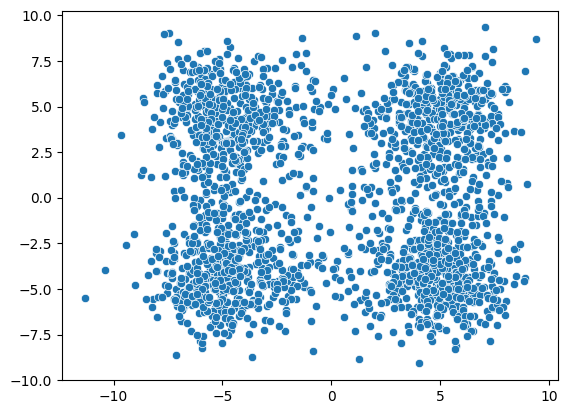

In [88]:
pca = PCA(n_components = 2)
tsne_res = pca.fit_transform(X)
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1],  palette = sns.hls_palette(10),legend=None)